# Mastering  用のコンプレッサー
* gainで指定されたレベルだけ上げる
* 指定されたthresholdからコンプレスを徐々に強め0dBで利得0dBとする

## 折り曲げるところはロジスティック関数を利用する 
$$
\begin{align}
f(x) = \frac{b}{1+e^{-ax}}
\end{align}
$$

In [9]:
import sympy as sp
#init_printing()
x = sp.Symbol('x')
a = sp.Symbol('a')
b = sp.Symbol('b')
fd = sp.diff( b / (1 + sp.exp(- a*x)), x )
fd

a*b*exp(-a*x)/(1 + exp(-a*x))**2

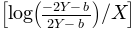

In [12]:
# x=0 の時の値は？
g = sp.Symbol('g')
X = sp.Symbol('X')
Y = sp.Symbol('Y')
A = sp.Symbol('A')
eq1 = a*b / 4 - g
#eq2 = b / (1+exp(-a*X)) - b / 2 -Y
eq2 = b / ( 1 + A ) - b / 2 - Y
sol2 = sp.solve( [eq2],[A])
eq3 = sp.exp(-a*X) - (-2*Y + b)/(2*Y + b)
sol3 = sp.solve( eq3, a)
eq4 = a - ( sp.log((-2*Y - b)/(2*Y - b))/X )

#solve( [ eq1, eq4], [a,b])
sp.init_printing()
sol3

## 解析的には難しそうなので数値解に路線変更
分岐点を原点として、下記関数をスケーリングすることで、傾きを保ったまま、最大値の値を変えることたできる。$g$は利得を表す。

$$
\begin{align}
f(x) = \frac{4}{1+e^{-gx}} - 2
\end{align}
$$


In [32]:
import scipy.io.wavfile as siw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

MAX_AMP = (32768)

class Compressor:
    "Compressor"
    def __init__(self, threshold=0, gain=0, ymax=0):
        gain_lin = 10.0 ** ( gain / 20.0) 
        xth_lin = int(MAX_AMP * 10.0**(threshold/20.0))
        yth_lin = gain_lin * xth_lin
        ymax_lin = MAX_AMP * 10.0**(ymax/20.0)
        print 'xth_lin', xth_lin, 'gain_lin', gain_lin, 'ymax_lin', ymax_lin
        
        xarea_normal = np.array( range(xth_lin) )
        xarea_comp = np.array( range(xth_lin, MAX_AMP+1) )
        X = xarea_comp[-1] - xarea_comp[0]
        Y = ymax_lin - yth_lin
        
        s_low = 0.00001
        s_high = 100000
        Yest = 100000
         
        while True:
            self.s_cur = ( s_low + s_high ) / 2.0
            Yest = self.logfn( X, gain_lin, self.s_cur )
            print 's_cur', self.s_cur, 'Yest', Yest, 'Y', Y            
            if abs(Yest - Y) < 1.0:
                break;
            if Yest < Y:
                s_high = self.s_cur
            else:
                s_low = self.s_cur
                       
        ycn = gain_lin * xarea_normal
        ycc = yth_lin + np.array( [ self.logfn( x, gain_lin, self.s_cur) for x in ( xarea_comp - xth_lin ) ] )
        yc = np.hstack( [ycn, ycc] )
        print yc[xth_lin], yc[-1] 
        
        for i in range(len(yc)):
            yc[i] = np.int16( min( MAX_AMP-1, np.round(yc[i])))
    
        self.table_ = {}
        for x in xarea_normal:
            self.table_[x] = yc[x]
        for x in xarea_comp:
            self.table_[x] = yc[x]
        for x in range(-MAX_AMP,0,1):
            self.table_[x] = -yc[-x]
                   
        print 'table_len', len(self.table_.values())
            
    def process(self,data):
        data2 = data.copy().ravel()
        for i in range(len(data2)):
            data2[i] = self.table_[data2[i]]
        return np.reshape( data2, data.shape )
    
    def logfn( self, x, gain, scale ):
        xs = scale * x
        ys = 4.0 / ( 1.0 + np.exp( -gain*xs ) ) - 2.0
        return ys/scale
    

Sampling rate : 48000
xth_lin 5827 gain_lin 2.81838293126 ymax_lin 32768.0
s_cur 50000.000005 Yest 3.9999999996e-05 Y 16345.2826595
s_cur 25000.0000075 Yest 7.9999999976e-05 Y 16345.2826595
s_cur 12500.0000088 Yest 0.000159999999888 Y 16345.2826595
s_cur 6250.00000938 Yest 0.00031999999952 Y 16345.2826595
s_cur 3125.00000969 Yest 0.000639999998016 Y 16345.2826595
s_cur 1562.50000984 Yest 0.00127999999194 Y 16345.2826595
s_cur 781.250009922 Yest 0.00255999996749 Y 16345.2826595
s_cur 390.625009961 Yest 0.00511999986944 Y 16345.2826595
s_cur 195.31250998 Yest 0.0102399994767 Y 16345.2826595
s_cur 97.6562599902 Yest 0.0204799979049 Y 16345.2826595
s_cur 48.8281349951 Yest 0.0409599916155 Y 16345.2826595
s_cur 24.4140724976 Yest 0.0819199664538 Y 16345.2826595
s_cur 12.2070412488 Yest 0.163839865799 Y 16345.2826595
s_cur 6.10352562439 Yest 0.327679463163 Y 16345.2826595
s_cur 3.05176781219 Yest 0.655357852589 Y 16345.2826595
s_cur 1.5258889061 Yest 1.31071141025 Y 16345.2826595
s_cur 0.762

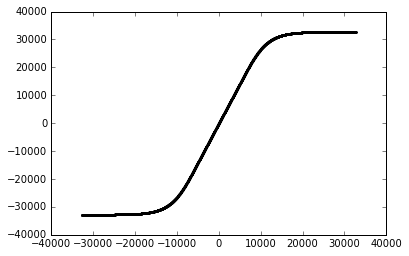

In [34]:
#wavfile = "./test.wav"
#wavfile = "../pydub/test/data/test1.wav"
wavfile = "./TimeLineMovie.wav"

fs, data = siw.read(wavfile)
print "Sampling rate :", fs

cmpres = Compressor( threshold=-15, gain=9 )
data2 = cmpres.process(data)        
siw.write( "test_out.wav",  fs, data2 )

plt.scatter( cmpres.table_.keys(), cmpres.table_.values(), s=1, marker='.' )
plt.show()

# 以下作業領域

32767.0
-32767.0
0.0


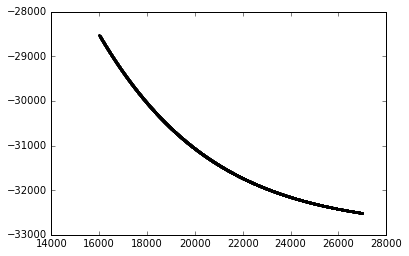

In [31]:
print cmpres.table_[32767]
print cmpres.table_[-32768]
print cmpres.table_[0]
yp = np.array([ cmpres.table_[i] for i in range(32768)])
yn = np.array([ cmpres.table_[i] for i in range(0,-32769,-1) ])
zoom = range(16000,27000,1)
ys = yn[zoom]
plt.scatter( zoom, ys, s=1 )
      

In [ ]:
threshold = -18
gain = 6
th_lin = int(MAX_AMP * 10.0**(threshold/20.0))
gain_lin = 10.0 ** ( gain / 20.0) 
print 'th_lin', th_lin, 'gain_lin', gain_lin
        
xarea_normal = np.array( range(th_lin) )
xarea_comp = np.array( range(th_lin, MAX_AMP+1) )
xarea_comp2 = np.power(xarea_comp, 2)
width = len(xarea_comp) - 1
width2 = float(width) * float(width)

ycn = gain_lin * xarea_normal
coef2 = - ( gain_lin - 1.0 )* MAX_AMP / width2
coef1 = ( gain_lin * ( MAX_AMP * MAX_AMP + th_lin * th_lin ) - 2.0 * MAX_AMP * th_lin ) / width2
coef0 = coef2 * th_lin * th_lin
ycc = coef2 * xarea_comp2 + coef1 * xarea_comp + coef0

yc = np.hstack( [ycn, ycc] )
print yc[th_lin], yc[-1]

In [ ]:
len(yc)
#ycs = yc[15000:20000]
ycs = yc
plt.scatter( range(len(ycs)), ycs)
plt.show()



In [ ]:
    def __initNG__(self, threshold=0, gain=0):
        th_lin = int(MAX_AMP * 10.0**(threshold/20.0))
        cmpzone = MAX_AMP - th_lin
        print th_lin, cmpzone
        
        self.gain_table_ = []
        for i in range(th_lin+1):
            self.gain_table_ += [ 10.0 ** ( gain / 20.0) ]
        for step, i in zip( range(1,cmpzone+1), range(th_lin+1, MAX_AMP+1)):
            ratio =  ( float(cmpzone) - float(step) ) / float(cmpzone)
 #           print "ratio", ratio
            self.gain_table_ += [ 10.0 ** ( ratio * gain /  20.0 ) ]
        print "gain_len", len(self.gain_table_)

        self.table_ = {}
        for i,j in zip( range(MAX_AMP+1), self.gain_table_ ):
            self.table_[i] = np.int16( min( MAX_AMP-1, np.round(i*j) ) )
            self.table_[-i] = - self.table_[i]
            
        print "table_len", len(self.table_.values())
            

In [ ]:
    def __initNG__(self, threshold=0, gain=0):
        th_lin = int(MAX_AMP * 10.0**(threshold/20.0))
        gain_lin = 10.0 ** ( gain / 20.0) 
        print 'th_lin', th_lin, 'gain_lin', gain_lin
        
        xarea_normal = np.array( range(th_lin) )
        xarea_comp = np.array( range(th_lin, MAX_AMP+1) )
        xarea_comp2 = np.power(xarea_comp, 2)
        width = len(xarea_comp) - 1
        width2 = float(width) * float(width)

        ycn = gain_lin * xarea_normal
        coef2 = - ( gain_lin - 1.0 )* MAX_AMP / width2
        coef1 = ( gain_lin * ( MAX_AMP * MAX_AMP + th_lin * th_lin ) - 2.0 * MAX_AMP * th_lin ) / width2
        coef0 = coef2 * th_lin * th_lin
        ycc = coef2 * xarea_comp2 + coef1 * xarea_comp + coef0

        yc = np.hstack( [ycn, ycc] )
        print yc[th_lin], yc[-1]       
        yc = map( lambda xx : np.int16( min( MAX_AMP-1, np.round(xx))), yc )
    
        self.table_ = {}
        for x in xarea_normal:
            self.table_[x] = yc[x]
        for x in xarea_comp:
            self.table_[x] = yc[x]
        for x in range(-MAX_AMP,0,1):
            self.table_[x] = -yc[-x]
                   
        print 'table_len', len(self.table_.values())